In [1]:
import os
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers

In [2]:
GPUs= tf.config.experimental.list_physical_devices("GPU")
if GPUs:
    try:
        for gpu in GPUs:
            tf.config.experimental.set_memory_growth(gpu,True)
        logical_gpus=tf.config.experimental.list_logical_devices("GPU")
        print(len(GPUs),"physical GPUs,",len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 physical GPUs, 1 Logical GPUs


In [3]:
ckpt_dir="./checkpoints/PGGAN"
re_dir="./results/PGGAN"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
if not os.path.exists(re_dir):
    os.makedirs(re_dir)

In [4]:
import ipynb_importer
from myutils import make_anime_dataset,visualize_result

importing Jupyter notebook from myutils.ipynb


In [5]:
def process_real_image(x,cur_res,alpha=1.0):
    x=tf.image.resize(x,(cur_res,cur_res))
    if (alpha >= 1.0) :
        return x
    else:
        y=tf.image.resize(x,(cur_res//2,cur_res//2))
        y=tf.image.resize(x,(cur_res,cur_res),method='bilinear')
        return lerp_clip(y,x,alpha)

def get_ckpt_path(cur_res):
    G_path=os.path.join(ckpt_dir,'generator{0}x{0}.h5'.format(cur_res))
    D_path=os.path.join(ckpt_dir,'discriminator{0}x{0}.h5'.format(cur_res))
    return D_path,G_path

def get_train_schedule(base_step=1000,increase_step=1000,target_res=64):
    res=4
    re={}
    while (res <= target_res):
        re[res]=base_step+increase_step*int(np.floor(np.log2(res/4)))
        res*=2
        
    return re
    
def prepare_model(resolution,G_before_D=False,load=False,same_res=False):
    D=Discriminator(resolution)
    G=Generator(resolution)
    
    if load is True:
        if not same_res:
            assert resolution > 4
            resolution=resolution//2
        D_path,G_path=get_ckpt_path(resolution)
        D.load_weights(D_path,by_name=True)
        G.load_weights(G_path,by_name=True)
    
    if G_before_D:
        return G,D
    else:
        return D,G

def prepare_optimizer(learning_rate,name):
    if (type(learning_rate) is float):
        d_lr=g_lr=learning_rate
    else:
        d_lr,g_lr=[learning_rate[0],learning_rate[1]]
    print('d_learning_rate={:.3e},g_learning_rate={:.3e}'.format(d_lr,g_lr))
    
    if (str.lower(name) == 'rmsprop'):
        d_optimizer= tf.keras.optimizers.RMSprop(learning_rate=d_lr)
        g_optimizer= tf.keras.optimizers.RMSprop(learning_rate=g_lr)
    elif (str.lower(name) == 'adam'):
        d_optimizer= tf.keras.optimizers.Adam(learning_rate=d_lr,beta_1=beta1,beta_2=beta2)
        g_optimizer= tf.keras.optimizers.Adam(learning_rate=g_lr,beta_1=beta1,beta_2=beta2)
    assert d_optimizer is not None
    return d_optimizer,g_optimizer

In [7]:
x=layers.Input((1,),name='GAlpha',ragged=True)
x

<tf.Tensor 'GAlpha:0' shape=(1,) dtype=float32>

In [34]:
def Generator(resolution=1024):
    resolution_log2=int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    
    inputs=layers.Input((100,),name='GInput')
    alpha=layers.Input((1,),name='GAlpha',ragged=True)
    
    x=g_ConvBlock(2,name='g_block{0}x{0}'.format(4))(inputs)
    image=toRGB(name='toRGB{0}x{0}'.format(4))(x)
    
    for i in range(3,resolution_log2+1):
        cur_res=2**i
        x=g_ConvBlock(i,name='g_block{0}x{0}'.format(cur_res))(x)
        img=toRGB(name='toRGB{0}x{0}'.format(cur_res))(x)
        
        if (i == resolution_log2):
            image=layers.UpSampling2D(interpolation='bilinear',name='upsample{}to{}'.format(cur_res//2,cur_res))(image)
            image=lerp_clip(image,img,alpha)
        else:
            image=img
            
    model=tf.keras.Model(inputs=[inputs,alpha],outputs=image)
    return model

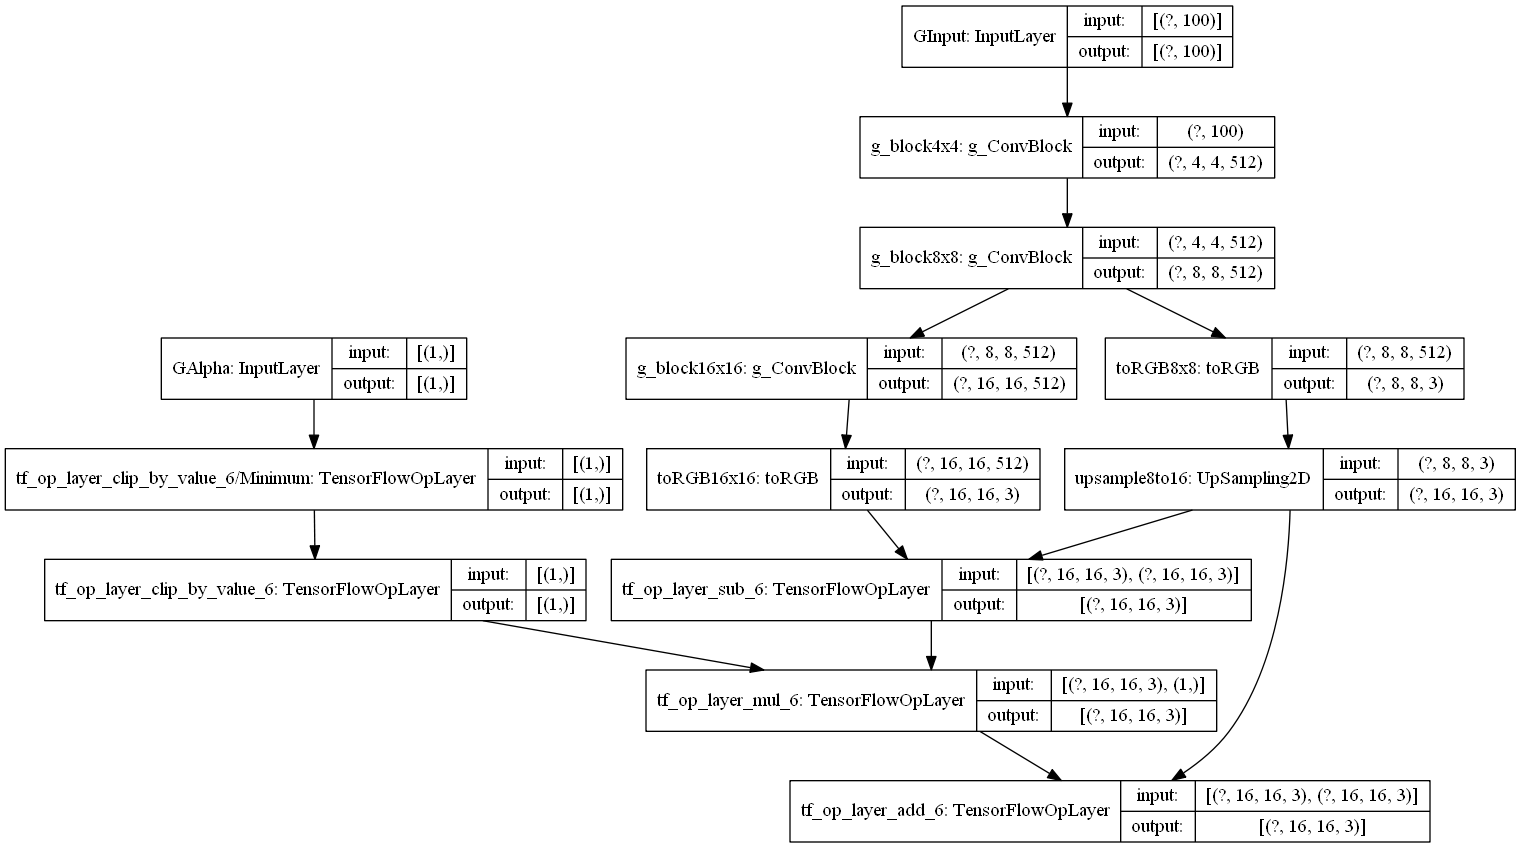

In [35]:
tf.keras.utils.plot_model(Generator(16),show_shapes=True)

In [10]:
def Discriminator(resolution=1024):
    resolution_log2=int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    
    inputs=layers.Input((resolution,resolution,3),name='DInput')
    alpha=layers.Input((1,),name='DAlpha',ragged=True)
    
    x=fromRGB(resolution_log2,name='fromRGB{0}x{0}'.format(resolution))(inputs)
    for i in range(resolution_log2,2,-1):
        cur_res=2**i
        x=d_ConvBlock(i,name='d_block{0}x{0}'.format(cur_res))(x)
        if (i == resolution_log2):
            img=layers.AvgPool2D(name='downsample{}'.format(i))(inputs)
            y=fromRGB(level=i-1,name='fromRGB{0}x{0}'.format(resolution//2))(img)
            x=lerp_clip(y,x,alpha)
    x=d_ConvBlock(2,name='d_block4x4')(x)
    
    model=tf.keras.Model(inputs=[inputs,alpha],outputs=x)
    return model

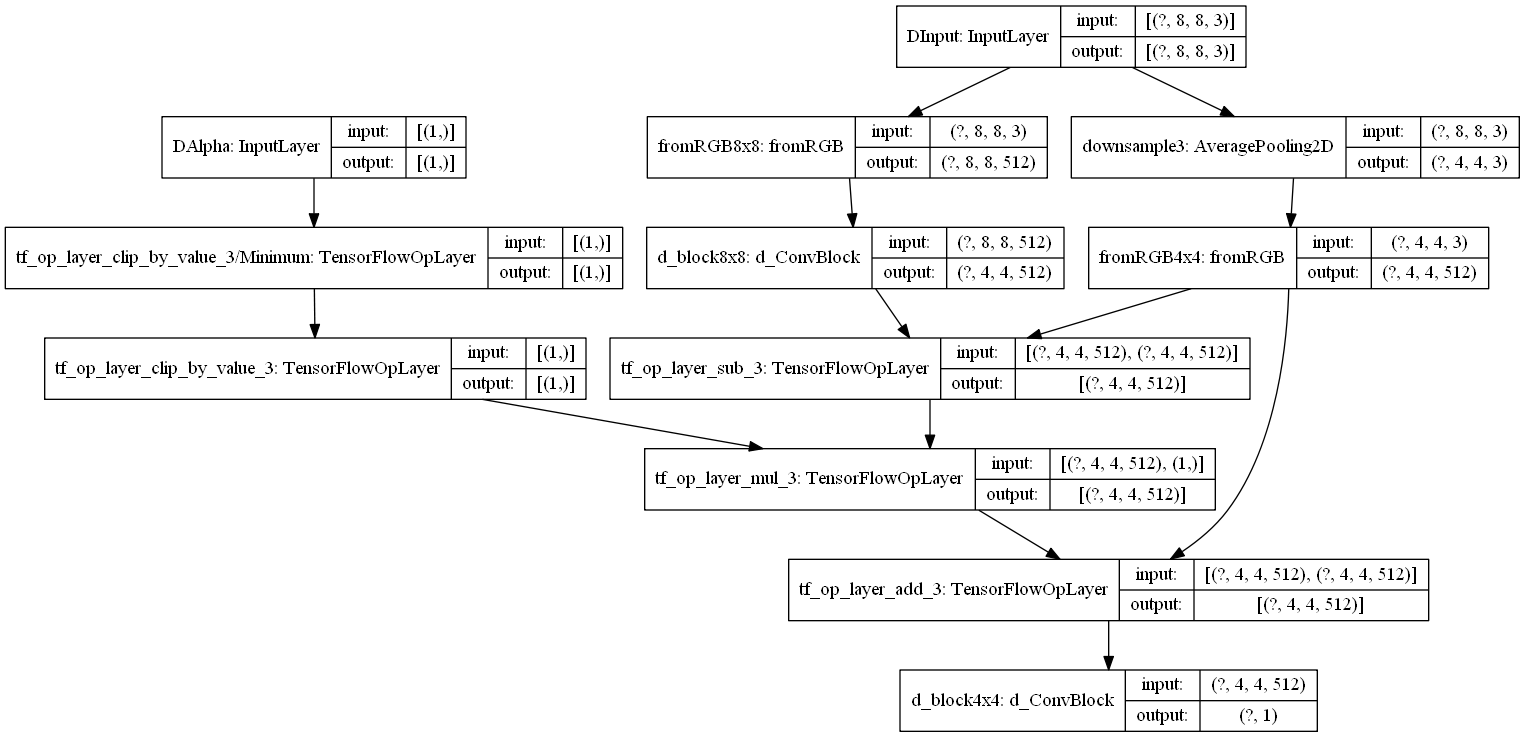

In [32]:
tf.keras.utils.plot_model(Discriminator(8),show_shapes=True)

In [11]:
class Conv2D(layers.Conv2D):
    def __init__(self,filters,kernel_size=3,strides=1,padding='same',use_bias=True,activation=tf.nn.leaky_relu,lrmul=1.0,**kargs):
        super().__init__(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,
                         use_bias=use_bias,activation=activation,kernel_initializer='he_normal',**kargs)
        
        fan_in=self.filters*np.prod(self.kernel_size)
        self.he_std=np.float32(np.sqrt(2/fan_in))
        
        self.lrmul=tf.Variable(lrmul,name=self.name+'_lrmul',trainable=False)
        
    def build(self,input_shape):
        super().build(input_shape)
        
    def call(self,inputs):
        x=self._convolution_op(inputs,self.kernel * self.he_std * self.lrmul)
        if self.use_bias:
            x=tf.nn.bias_add(x,self.bias * self.lrmul,data_format='NHWC')
        if self.activation is not None:
            x=self.activation(x)
        return x
    
class Dense(layers.Dense):
    def __init__(self,filters,use_bias=True,activation=tf.nn.leaky_relu,lrmul=1.0,**kargs):
        super().__init__(filters,use_bias=use_bias,activation=activation,kernel_initializer='he_normal',**kargs)
        
        fan_in=self.units
        self.he_std=np.float32(np.sqrt(2/fan_in))
        
        self.lrmul=tf.Variable(lrmul,name=self.name+'_lrmul',trainable=False)
        
    def build(self,input_shape):
        super().build(input_shape)
        
    def call(self,inputs):
        if (len(inputs.shape) > 2):
            inputs=tf.reshape(inputs,[-1,np.prod(x.shape[1:])])
        
        x=tf.matmul(inputs,self.kernel * self.he_std * self.lrmul)
        if self.use_bias:
            x=tf.nn.bias_add(x,self.bias * self.lrmul,data_format='NHWC')
        if self.activation is not None:
            x=self.activation(x)
        return x    

In [12]:
class WScaleLayer(layers.Layer):
    def __init__(self,layer,activation=None,name=None,use_bias=True,**kargs):
        super(WScaleLayer,self).__init__(name=name)
        
        if name is None: name=''
        if isinstance(layer,layers.Dense):
            self.filters=K.get_value(layer.units)
            fan_in=self.filters
        elif isinstance(layer,layers.Conv2D):
            self.filters=K.get_value(layer.filters)
            fan_in=K.get_value(layer.filters)*np.prod(K.get_value(layer.kernel_size))
        else:
            raise TypeError
            
        std=np.float32(np.sqrt(2/fan_in))
        self.wscale=self.add_weight(name=name+'_wscale',shape=std.shape,trainable=False)
        K.set_value(self.wscale,std)
        
        self.activation=activation
        self.use_bias=use_bias
        
    def build(self,input_shape):
        if self.use_bias:
            self.bias = self.add_weight(name=self.name+'_bias',shape=(self.filters,),trainable=True)
        
    def call(self,inputs):
        x=inputs*self.wscale
        if self.use_bias:
            x=tf.nn.bias_add(x,self.bias,data_format='NHWC')
        if self.activation:
            x=self.activation(x)
        return x    
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [13]:
class g_ConvBlock(tf.keras.Model):
    def __init__(self,level,kernel_size=3,norm_latent=True,name=None):
        super(g_ConvBlock,self).__init__(name=name)
        
        assert level >=2
        self.level=level
        self.norm_latent=norm_latent
        
        if level > 2:
            self.upsample=layers.UpSampling2D(interpolation='bilinear',name=name+'_upsample')
            self.conv1=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv1')
            self.conv2=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv2')
        else:
            self.fc=Dense(nf(1)*16,name=name+'_dense')
            self.conv=Conv2D(nf(1),kernel_size=kernel_size,strides=1,name=name+'_conv')
            
    def call(self,inputs,training=False):
        if self.level > 2:
            x=self.upsample(inputs)
            x=PN(self.conv1(x))
            x=PN(self.conv2(x))
        else:
            if self.norm_latent:
                inputs=PN(inputs)
            x=PN(self.fc(inputs))
            x=tf.reshape(x,[-1,4,4,nf(1)])
            x=PN(self.conv(x))
        
        return x
    
class toRGB(tf.keras.Model):
    def __init__(self,filters=3,name=None):
        super(toRGB,self).__init__(name=name)
        
        self.conv=Conv2D(filters=filters,kernel_size=1,strides=1,activation=None,name=name+'_conv')
        
    def call(self,inputs,training=None):
        x=self.conv(inputs)
        return x
    
class d_ConvBlock(tf.keras.Model):
    def __init__(self,level,kernel_size=3,mbstd_groups_size=4,features=1,name=None):
        super(d_ConvBlock,self).__init__(name=name)
        
        assert level >=2
        self.level=level
        
        if level > 2:
            self.conv1=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv1')
            self.conv2=Conv2D(nf(level-2),kernel_size=kernel_size,strides=1,name=name+'_conv2')
            self.downsample=layers.AveragePooling2D(name=name+'_downsample')
        else:
            if mbstd_groups_size > 1:
                self.mbstd=MinibatchStd(mbstd_groups_size,features,name=name+'_mbstd')
            self.conv=Conv2D(nf(1),kernel_size=kernel_size,strides=1,name=name+'_conv')
            self.flatten=layers.Flatten(name=name+'_flatten')
            self.fc1=Dense(nf(0),name=name+'_dense1')
            self.fc2=Dense(1,activation=None,name=name+'_dense2')
    
    def call(self,inputs,training=False):
        if self.level > 2:
            x=self.conv1(inputs)
            #x=_blur2d(x)
            x=self.conv2(x)
            x=self.downsample(x)
        else:
            if self.mbstd is not None:
                inputs=self.mbstd(inputs)
            x=self.conv(inputs)
            x=self.flatten(x)
            x=self.fc1(x)
            x=self.fc2(x)
        
        return x

class fromRGB(tf.keras.Model):
    def __init__(self,level,name=None):
        super(fromRGB,self).__init__(name=name)
        
        self.conv=Conv2D(filters=nf(level-1),kernel_size=1,strides=1,name=name+'_conv')
        
    def call(self,inputs,training=None):
        x=self.conv(inputs)
        return x

class MinibatchStd(layers.Layer):
    def __init__(self,group_size,num_new_features,**kargs):
        super(MinibatchStd,self).__init__(**kargs)
        self.group_size=group_size
        self.num_new_features=num_new_features
    
    def call(self,x,training=None):
        x=tf.transpose(x,perm=[0,3,1,2])# [NHWC]->[NCHW]
        group_size=tf.minimum(self.group_size,tf.shape(x)[0])
        s=x.shape
        y=tf.reshape(x,
                    [self.group_size,-1,self.num_new_features,s[1]//self.num_new_features,s[2],s[3]])
        y=tf.cast(y,tf.float32)
        y-=tf.reduce_mean(y,axis=0,keepdims=True)
        y=tf.reduce_mean(tf.square(y),axis=0)
        y=tf.sqrt(y+1e-8)
        y=tf.reduce_mean(y,axis=[2,3,4],keepdims=True)
        y=tf.reduce_mean(y,axis=[2])
        y=tf.cast(y,x.dtype)
        y=tf.tile(y,[self.group_size,1,s[2],s[3]])
        x=tf.concat([x,y],axis=1)
        x=tf.transpose(x,perm=[0,2,3,1])
        return x

In [14]:
def PN(x,epsilon=1e-8):
    if len(x.shape) > 2:
        axis=3
    else:
        axis=1
    return x/tf.sqrt(tf.reduce_mean(tf.square(x),axis=axis,keepdims=True)+epsilon)

def lerp_clip(a,b,t):
    return a+(b-a)*tf.clip_by_value(t,0.0,1.0)

def nf(stage, fmap_base=8192, fmap_decay=1.0, fmap_max=512): 
    return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)

In [25]:
@tf.function
def gradient_penalty(D,real,fake,alpha):
    batchsz=real.shape[0]
    
    t=tf.random.uniform([batchsz,1,1,1])
    t=tf.broadcast_to(t, real.shape)
    interplate= t*real + (1-t)*fake
    
    with tf.GradientTape() as tape:
        tape.watch([interplate])
        d_interplate_logits=D([interplate,alpha])
    grads=tape.gradient(d_interplate_logits,interplate)
    
    grads=tf.reshape(grads,[grads.shape[0], -1])
    gp=tf.norm(grads,axis=1)
    gp=tf.reduce_mean((gp-1)**2)
    return gp

def d_loss_fn(G,D,noise,batch_x,alpha):
    fake_image= G([noise,alpha])
    d_fake_logits= D([fake_image,alpha])
    d_real_logits= D([batch_x,alpha])
    
#     t=K.random_uniform((batch_x.shape[0],1,1,1))
#     t=tf.broadcast_to(t,batch_x.shape)
#     interplate=t*batch_x + (1-t)*fake_image

#     with tf.GradientTape() as tape:
#         tape.watch([interplate])
#         d_interplate_logits=D([interplate,alpha])
#     grads=tape.gradient(d_interplate_logits,interplate)
#     grads=tf.reshape(grads,[grads.shape[0],-1])
#     gp=tf.norm(grads,axis=1)
#     gp=tf.reduce_mean((grads-1.)**2)

    gp=gradient_penalty(D,batch_x,fake_image,alpha)
    W=tf.reduce_mean(d_fake_logits - d_real_logits)
    loss=W + gp_lambda*gp

    return loss,d_real_logits,W

def g_loss_fn(G,D,noise,batch_x,alpha):
    fake_image= G([noise,alpha])
    d_fake_logits= D([fake_image,alpha])
    loss=tf.reduce_mean(-d_fake_logits)
    
    return loss

In [16]:
def D_train_step(G,D,x,y=None,alpha=1.0):
    noise= np.float32(np.random.normal(0,1,(batch_size,z_dim)))
    with tf.GradientTape() as tape:
        d_loss,real_logits,W= d_loss_fn(G,D,noise,x,alpha)
    grads = tape.gradient(d_loss, D.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, D.trainable_variables))
    return d_loss,tf.reduce_mean(real_logits),W
   
def G_train_step(G,D,x,y=None,alpha=1.0):
    noise= np.float32(np.random.normal(0,1,(batch_size,z_dim)))
    with tf.GradientTape() as tape:
        g_loss= g_loss_fn(G,D,noise,x,alpha)
    grads = tape.gradient(g_loss, G.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, G.trainable_variables))
    return g_loss

In [17]:
class LRReducer:
    def __init__(self,factor=0.1,patience=500,min_delta=1,min_lr=1e-7,verbose=0):
        self.factor=factor
        self.patience=patience
        self.min_delta=min_delta
        self.min_lr=min_lr
        self.verbose=verbose
        
        self.reset()
        
    def reset(self):
        self.count=0
        self.wait=0
        self.best=99999
        
    def on_shifting(self,force=False):
        if (force and self.count == 0):
            self.work()
        self.reset()
        
    def watch(self,W,threshold=0.1):
        if (abs(W) < self.best-self.min_delta):
            self.best=W
            self.wait=0
        elif (abs(W) < threshold):
#             self.wait=int(self.wait*0.9)
            pass
        else:
            self.wait+=1
            if (self.wait >= self.patience):
                self.wait=0
                self.count+=1
                self.work()
                
    def work(self): 
        global cur_lr,d_optimizer,g_optimizer
        cur_lr=max(cur_lr*self.factor, self.min_lr)
        K.set_value(d_optimizer.lr,cur_lr)
        K.set_value(g_optimizer.lr,cur_lr)
        if self.verbose > 0:
            print("Learning rate reduced to %.3e" % (cur_lr))

In [18]:
class TrainScheduler:
    '''
    需要预先定义skpt_dir，在该文件夹下以txt的形式保存训练进度
    会恢复cur_res,cur_lr,resume_step；D,G及其optimizer
    '''
    def __init__(self,resume=False):
        global ckpt_dir
        self.sch_path=os.path.join(ckpt_dir,'schedule.txt')
        if not os.path.exists(self.sch_path):
            with open(self.sch_path,'w') as f:
                f.write('')
        elif resume is True:
            self.resume_train()
    
        
    def pause_train(self):
        global resume_step,step
        try:
            loc_step=resume_step+step
        except NameError:
            loc_step=step
        f=open(self.sch_path,'r+')
        f.truncate()
        print('cur_res=%d' % cur_res,'step=%d' % loc_step,'cur_lr=%e' % cur_lr,sep='\n',file=f)
        f.close()
        
    
    def resume_train(self):
        global cur_res,cur_lr,resume_step,D,G,d_optimizer,g_optimizer
        
        def get_digit_string(f):
            s=f.readline()
            print(s)
            pos=s.find('=')+1
            return s[pos:]

        f=open(self.sch_path,'r+')
        cur_res=int(get_digit_string(f))
        resume_step=int(get_digit_string(f))
        cur_lr=float(get_digit_string(f))
        f.close()
        
        D,G=prepare_model(cur_res,load=True,same_res=True)

In [19]:
#准备数据集
input_size=64
z_dim=100
batch_size=4

paths= glob(r'.\faces\*.jpg')
print("read images of",len(paths))
dataset,size= make_anime_dataset(paths,batch_size,resize=(input_size,input_size),return_size=True)
print(size)
data_iter=iter(dataset)

read images of 51223
(64, 64, 3)


In [26]:
D,G=prepare_model(4)

beta1=0.
beta2=0.99
learning_rate=1e-3
d_optimizer,g_optimizer=prepare_optimizer(learning_rate,name='adam')

d_learning_rate=1.000e-03,g_learning_rate=1.000e-03


In [27]:
train_sch=TrainScheduler()

In [28]:
cur_res=4
cur_lr=learning_rate
gp_lambda=10.

ReduceLR=LRReducer(factor=0.1,patience=2000,min_delta=0.1,verbose=1)

alpha=1.0
shift_step=3000
alpha_increase=1.0/shift_step

train_schedule=get_train_schedule(base_step=int(5e3),increase_step=-int(1e3))
print(train_schedule)

{4: 5000, 8: 4000, 16: 3000, 32: 2000, 64: 1000}


In [29]:
if 0:
    train_sch.resume_train()

step= 0000, d_loss= 0.1728957295, g_loss= -28.9711952209, d_real= 29.1488800049, EM_dist= -0.0987653732


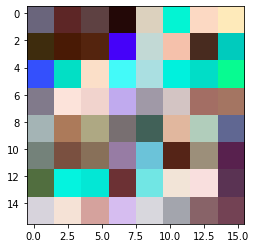

step= 0050, d_loss= -2.3244109154, g_loss= -30.8998718262, d_real= 33.5489044189, EM_dist= -2.6113281250


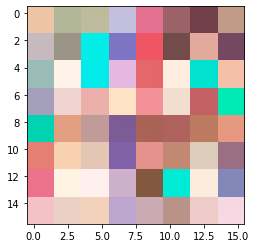

step= 0100, d_loss= 0.4025886059, g_loss= -31.0158271790, d_real= 31.5714073181, EM_dist= -0.4749827385


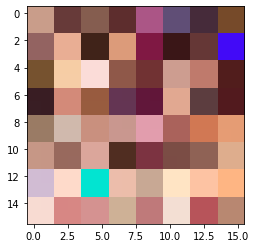

step= 0150, d_loss= -0.9448984861, g_loss= -31.5223636627, d_real= 33.3534698486, EM_dist= -1.7593407631


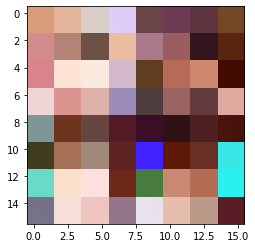

step= 0200, d_loss= 2.5897879601, g_loss= -31.9518356323, d_real= 30.6542797089, EM_dist= 2.2000770569


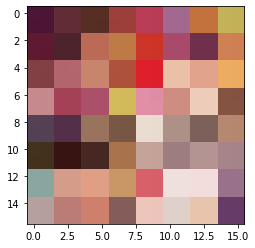

step= 0250, d_loss= -0.6014638543, g_loss= -31.5779056549, d_real= 32.6939239502, EM_dist= -1.1427049637


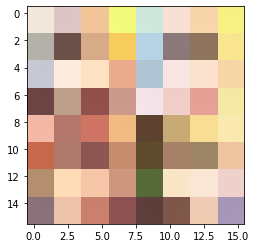

step= 0300, d_loss= -1.1114785671, g_loss= -32.1318244934, d_real= 34.8910255432, EM_dist= -2.5587673187


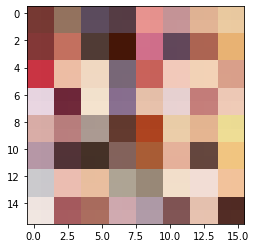

step= 0350, d_loss= 2.4302887917, g_loss= -33.8028640747, d_real= 31.7160778046, EM_dist= 2.2362742424


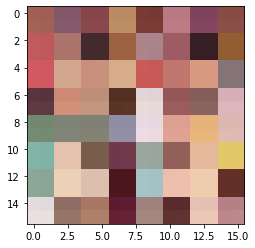

step= 0400, d_loss= 0.5430568457, g_loss= -34.2355575562, d_real= 34.1809272766, EM_dist= 0.0680742264


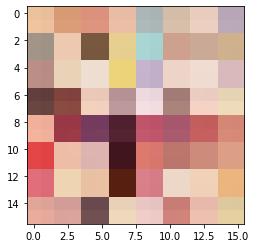

step= 0450, d_loss= 0.7313914895, g_loss= -36.9896087646, d_real= 36.4912567139, EM_dist= 0.5752334595


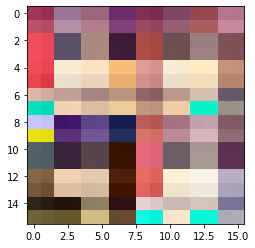

step= 0500, d_loss= 1.9569394588, g_loss= -38.4515457153, d_real= 37.1614875793, EM_dist= 1.1712179184


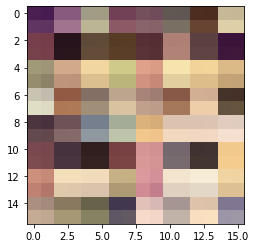

step= 0550, d_loss= 1.2887382507, g_loss= -42.2120933533, d_real= 41.6658401489, EM_dist= 0.4058828354


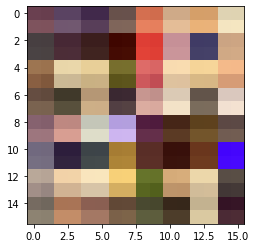

step= 0600, d_loss= 1.9666564465, g_loss= -45.1047706604, d_real= 43.3574790955, EM_dist= 1.6328620911


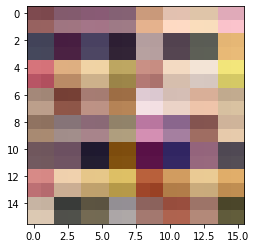

step= 0650, d_loss= 1.4248831272, g_loss= -46.9772377014, d_real= 46.1331977844, EM_dist= 0.8047723770


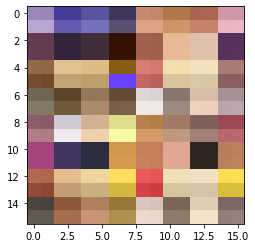

step= 0700, d_loss= 0.2382548451, g_loss= -47.1181182861, d_real= 47.6055984497, EM_dist= -0.5838356018


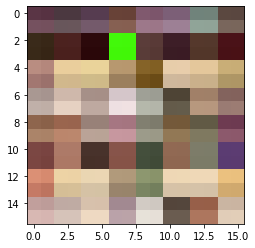

step= 0750, d_loss= 0.6791385412, g_loss= -54.2174034119, d_real= 54.9465255737, EM_dist= -0.4794540405


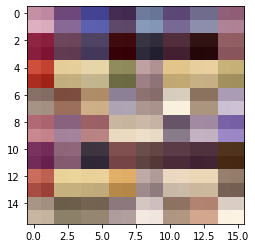

step= 0800, d_loss= 2.4308600426, g_loss= -47.6855773926, d_real= 48.0213012695, EM_dist= 2.0243635178


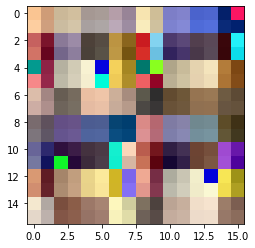

step= 0850, d_loss= 1.9102752209, g_loss= -44.9476661682, d_real= 43.9934768677, EM_dist= 0.7572002411


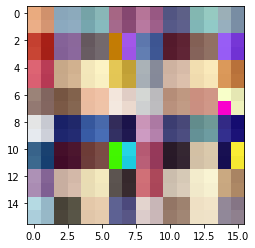

step= 0900, d_loss= 1.2294284105, g_loss= -45.3924865723, d_real= 44.4381790161, EM_dist= 1.0204858780


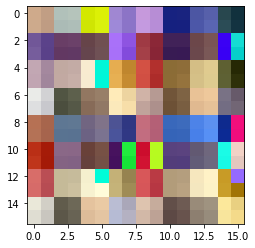

step= 0950, d_loss= 1.0155398846, g_loss= -45.3160133362, d_real= 44.7180023193, EM_dist= 0.5789108276


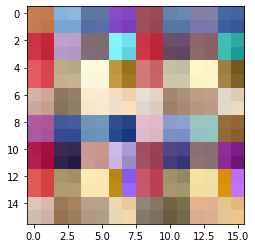

step= 1000, d_loss= 1.2427067757, g_loss= -44.3197860718, d_real= 43.5641250610, EM_dist= 0.4371805191


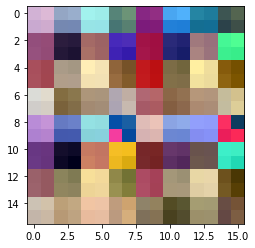

step= 1050, d_loss= 0.4454199672, g_loss= -44.5579109192, d_real= 44.2526359558, EM_dist= 0.3430099487


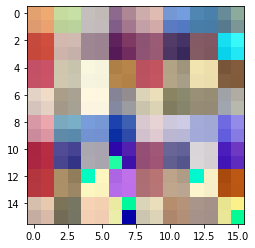

step= 1100, d_loss= 0.5377261639, g_loss= -44.2760238647, d_real= 43.9587249756, EM_dist= 0.1553010941


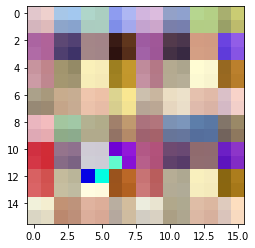

step= 1150, d_loss= 0.6609938145, g_loss= -44.5726928711, d_real= 44.2089614868, EM_dist= 0.1817255020


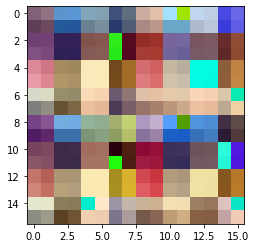

step= 1200, d_loss= 0.2857162654, g_loss= -46.4059753418, d_real= 46.4588165283, EM_dist= -0.1639976501


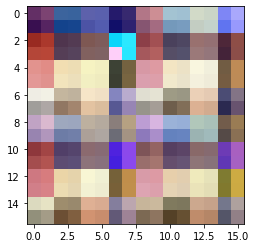

step= 1250, d_loss= 2.5405733585, g_loss= -47.9928131104, d_real= 46.4368095398, EM_dist= 1.9025917053


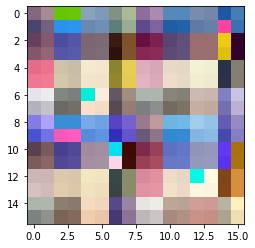

1273/7000 Learning rate reduced to 1.000e-05
step= 1300, d_loss= 1.0742526054, g_loss= -46.8337020874, d_real= 46.0377883911, EM_dist= 0.7936611176


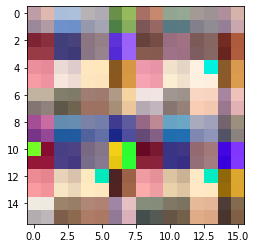

step= 1350, d_loss= 1.7836946249, g_loss= -47.0172424316, d_real= 46.1669616699, EM_dist= 0.8965730667


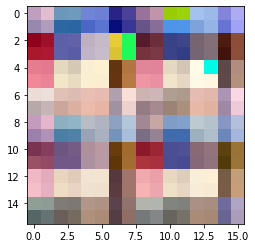

step= 1400, d_loss= 2.4902875423, g_loss= -46.5630950928, d_real= 45.6364593506, EM_dist= 0.9794769287


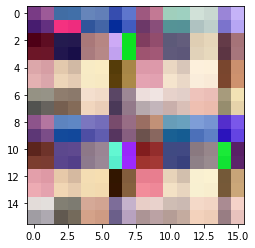

step= 1450, d_loss= 2.4718394279, g_loss= -47.1926116943, d_real= 46.5627593994, EM_dist= 0.6146717072


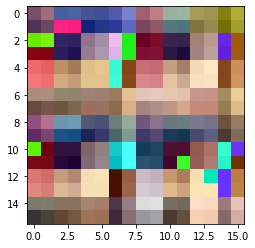

step= 1500, d_loss= 1.4012768269, g_loss= -47.4117813110, d_real= 46.9118347168, EM_dist= 0.5373573303


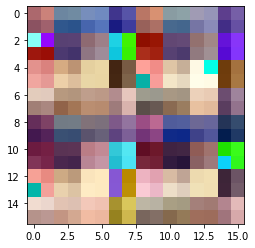

step= 1550, d_loss= 1.8860619068, g_loss= -47.4907302856, d_real= 46.8610153198, EM_dist= 0.6608190536


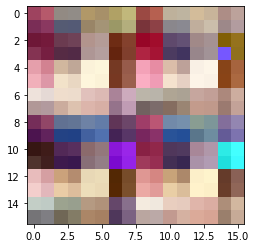

step= 1600, d_loss= 2.4947280884, g_loss= -47.5191116333, d_real= 46.8600463867, EM_dist= 0.6469488144


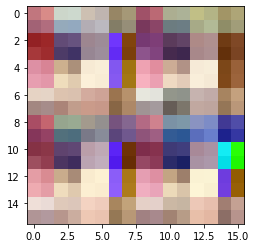

step= 1650, d_loss= 2.1678686142, g_loss= -47.5202484131, d_real= 47.1476440430, EM_dist= 0.3843126297


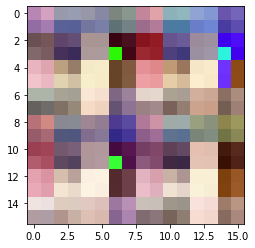

step= 1700, d_loss= 4.5015721321, g_loss= -47.7333183289, d_real= 46.3357734680, EM_dist= 1.3497600555


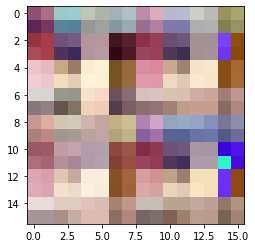

step= 1750, d_loss= 2.5442171097, g_loss= -47.8491744995, d_real= 47.2692031860, EM_dist= 0.6325712204


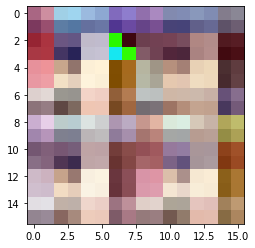

step= 1800, d_loss= 1.0983827114, g_loss= -48.4454956055, d_real= 47.9303665161, EM_dist= 0.5395250320


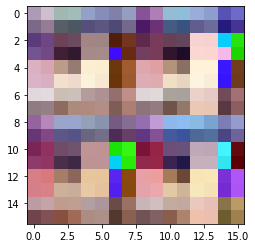

step= 1850, d_loss= 2.2353227139, g_loss= -48.4481620789, d_real= 47.9244422913, EM_dist= 0.5211935043


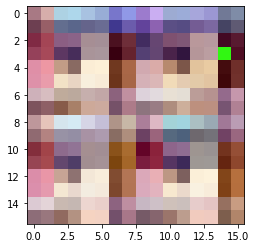

step= 1900, d_loss= 2.7069740295, g_loss= -48.7341232300, d_real= 48.3727035522, EM_dist= 0.3647146225


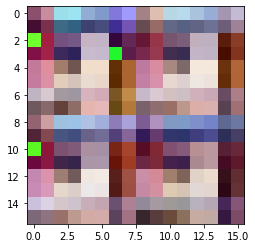

step= 1950, d_loss= 2.0878381729, g_loss= -48.6630630493, d_real= 48.2575874329, EM_dist= 0.4293804169


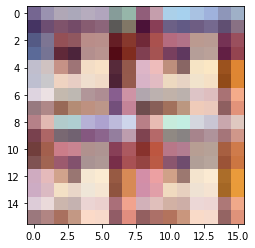

step= 2000, d_loss= 3.9801435471, g_loss= -48.4113388062, d_real= 47.5851211548, EM_dist= 0.8187971115


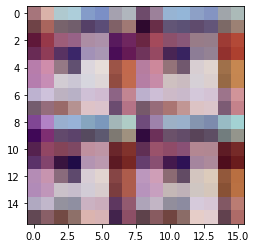

step= 2050, d_loss= 5.0195913315, g_loss= -49.2119522095, d_real= 47.4996643066, EM_dist= 1.6691684723


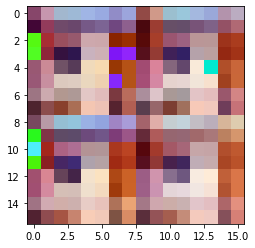

step= 2100, d_loss= 1.3435747623, g_loss= -49.4451141357, d_real= 48.5566787720, EM_dist= 0.8750028610


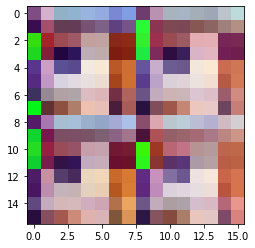

step= 2150, d_loss= 2.6501867771, g_loss= -49.3637161255, d_real= 48.4643325806, EM_dist= 0.8745307922


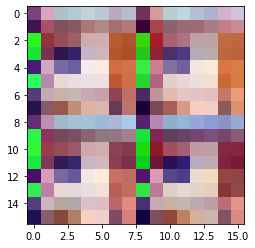

step= 2200, d_loss= 2.4848239422, g_loss= -49.5374717712, d_real= 48.8800430298, EM_dist= 0.6497240067


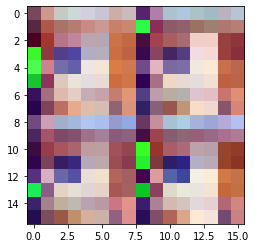

step= 2250, d_loss= 2.6930341721, g_loss= -49.7745170593, d_real= 49.0374145508, EM_dist= 0.7293796539


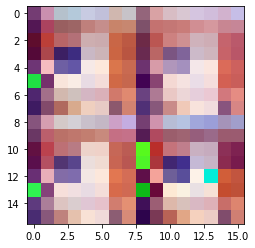

step= 2300, d_loss= 1.5866143703, g_loss= -52.6793861389, d_real= 51.6630859375, EM_dist= 1.0380239487


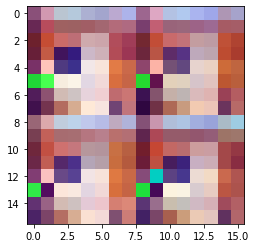

step= 2350, d_loss= 3.6025106907, g_loss= -53.1194458008, d_real= 51.9490966797, EM_dist= 1.2051334381


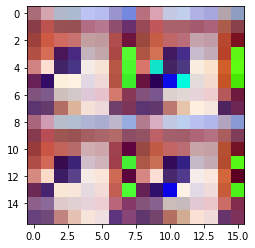

step= 2400, d_loss= 3.4783477783, g_loss= -53.1944503784, d_real= 51.9376449585, EM_dist= 1.2683296204


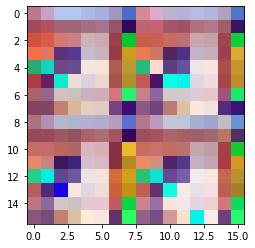

step= 2450, d_loss= 1.9930711985, g_loss= -53.2462158203, d_real= 51.7925567627, EM_dist= 1.4485530853


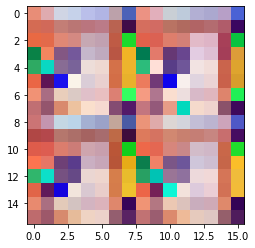

step= 2500, d_loss= 2.5462970734, g_loss= -53.5632553101, d_real= 52.4871368408, EM_dist= 1.1190013885


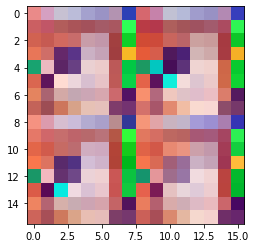

step= 2550, d_loss= 3.7664887905, g_loss= -53.2431793213, d_real= 52.0232200623, EM_dist= 1.2222290039


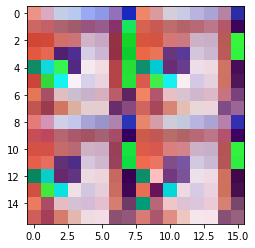

step= 2600, d_loss= 4.4677004814, g_loss= -53.3533744812, d_real= 50.9938659668, EM_dist= 2.3660955429


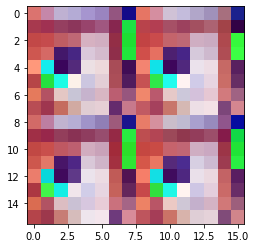

step= 2650, d_loss= 10.5660820007, g_loss= -53.5063629150, d_real= 50.8938217163, EM_dist= 2.5513496399


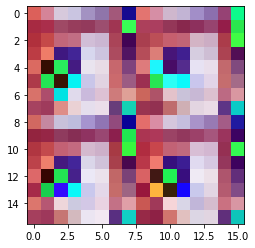

step= 2700, d_loss= 4.0515556335, g_loss= -53.3686218262, d_real= 51.5386276245, EM_dist= 1.8346042633


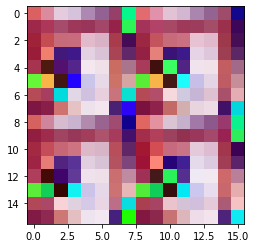

step= 2750, d_loss= 3.7433815002, g_loss= -53.5762023926, d_real= 51.6864624023, EM_dist= 1.9039936066


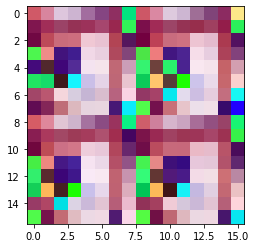

step= 2800, d_loss= 3.4706232548, g_loss= -53.6600418091, d_real= 52.5555725098, EM_dist= 1.1016817093


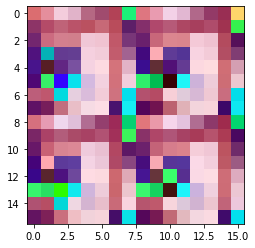

step= 2850, d_loss= 5.7972507477, g_loss= -53.2163505554, d_real= 51.5700569153, EM_dist= 1.6149816513


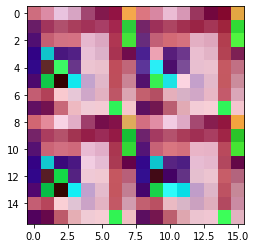

step= 2900, d_loss= 2.4919576645, g_loss= -53.4364547729, d_real= 51.5340423584, EM_dist= 1.9052238464


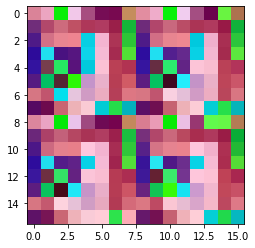

step= 2950, d_loss= 4.6795597076, g_loss= -53.6079139709, d_real= 52.0818252563, EM_dist= 1.5089120865


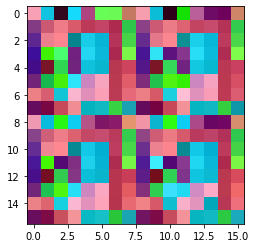

2999/7000 Alpha reaches 1.0
step= 3000, d_loss= 3.1069803238, g_loss= -53.3490676880, d_real= 51.2321434021, EM_dist= 2.1083221436


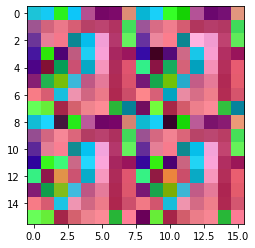

3034/7000 Interrupted
Train End


In [36]:
while (cur_res <= input_size):
    if (cur_res == 4):
        total_step=train_schedule[4]
    else:
        total_step=shift_step+train_schedule[cur_res]
        
    try:
        total_step-=resume_step
        alpha=alpha_increase*resume_step
    except NameError:
        pass
    
    try:
        for step in range(total_step+1):
            #准备数据
            if (cur_res > 4 and step == shift_step):
                print("Alpha reaches 1.0")
            print("\r%04d/%04d " % (step,total_step),end='')
            alpha+=alpha_increase
            x=next(data_iter)[0]
            x=process_real_image(x,cur_res,alpha)

            #训练
            d_loss,d_real,W = D_train_step(G,D,x,alpha)
            g_loss = G_train_step(G,D,x,alpha)
            ReduceLR.watch(W)

            #可视化与保存
            if step%50 == 0 :
                print("\rstep= %04d, d_loss= %.10f, g_loss= %.10f, d_real= %.10f, EM_dist= %.10f"
                          % (step,float(d_loss),float(g_loss),float(d_real),W))
                noise= np.float32(np.random.normal(0,1,(batch_size,z_dim)))
                img_path=os.path.join(re_dir,"PGGAN{0}x{0}_{1:04d}.jpg".format(cur_res,step))
                visualize_result(G,[noise,alpha],save_path=img_path,save=True,rewind=False)

                if (step%100 == 0 and step != 0):
                    #保存
                    D_path,G_path=get_ckpt_path(cur_res)
                    D.save_weights(D_path)
                    G.save_weights(G_path)


        if (cur_res*2 > input_size): break

        print('change resolution from %d to %d' % (cur_res,cur_res*2))
        D_path,G_path=get_ckpt_path(cur_res)
        D.save_weights(D_path)
        G.save_weights(G_path)

        resume_step=0
        alpha=0.0
        cur_res*=2
        D,G=prepare_model(cur_res,load=True)
        ReduceLR.on_shifting()
        visualize_result(G,[noise,alpha], save=False,rewind=True)
        print('start training at {0}x{0}'.format(cur_res))
        print("Current learning rate=%.3e" % (cur_lr))
    except KeyboardInterrupt:
        train_sch.pause_train()
        print("Interrupted")
        break
            
print("Train End")